In [1]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

import torch_geometric

Torch vers:  2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np
import pandas as pd
import os
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric
from torch.nn import Parameter
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import urllib.request
import tarfile
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

### PubMED Dataset ###

In [3]:
# Load the PubMMed dataset
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

Processing...
Done!


In [4]:
data

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])

This dataset has some nodes which are masked, the training loop is also appropriately modified for the masking.

In [5]:
# view the dataset details
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3


The PubMed dataset consists of scientific publications from the PubMed database on types of diabetes classified into one of three classes

* Diabetes Mellitus Experimental
* Diabetes Mellitus Type_1
* Diabetes Mellitus Type_2
The citation network consists of 44,338 links. Each publication in the dataset is described by a TF/IDF weighted word vector from a dictionary which consists of 500 unique words.

Node classification into one of the above categories using GCN, GraphSAGE, and GAT

In [6]:
# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')


Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


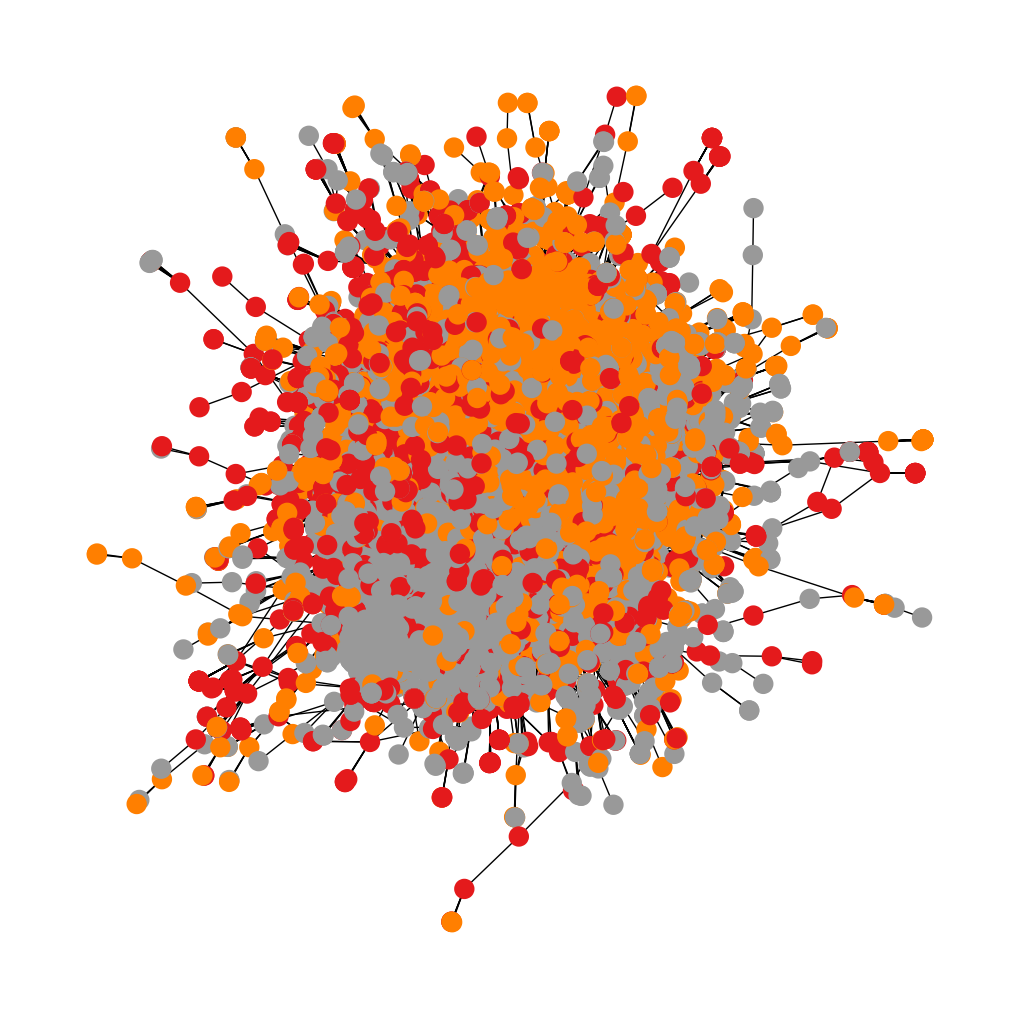

In [7]:
#Visualize the graph using networkx
plt.figure(figsize=(10, 10))
pubmed = torch_geometric.data.Data(x=data.x[:500], edge_index=data.edge_index[:500])
g = torch_geometric.utils.to_networkx(pubmed, to_undirected=True)
pubmedGraph = to_networkx(pubmed)
node_labels = data.y[list(pubmedGraph.nodes)].numpy()
nx.draw(g, cmap=plt.get_cmap('Set1'),node_color = node_labels,node_size=75,linewidths=6)


In [8]:
#set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
# Create batches with neighbor sampling
#A NeighborLoader is a data loader that performs neighbor sampling for GNN's
#Allows for mini-batch training of GNNs on large-scale graphs where full-batch training is not feasible.
#num_neighbors denotes how many neighbors are sampled for each node in each iteration.
#https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

/usr/local/lib/python3.9/dist-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


### GCN ###

In [10]:
'''
Graph Convolutional Network
GCN takes graphs as an input and applies convolution operations over the graph
'''
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)
    def forward(self, x, edge_index):
        # x: Node feature matrix 
        # edge_index: Graph connectivity matrix 
        #x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x, F.log_softmax(x, dim=1)

### GraphSage ###

In [11]:
'''
Graph SAGE: SAmpling and aggreGatE, 
Samples only a subset of neighboring nodes at different depth layers, 
and then the aggregator takes neighbors of the previous layers and aggregates them
'''
class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h*2)
    self.sage2 = SAGEConv(dim_h*2, dim_h)
    self.sage3 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.2, training=self.training)
    h = self.sage3(h, edge_index)
    return h, F.log_softmax(h, dim=1)

### GAT ###

In [12]:
'''
GAT- uses Attention stratgey
compute the hidden representations of each node in the Graph by attending 
over its neighbors using a self-attention strategy
'''
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)

    def forward(self,x, edge_index):
        
        # Dropout before the GAT layer is used to avoid overfitting
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x,F.log_softmax(x, dim=1)



### Training Loop for the PubMED case ###

In [13]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data, epochs):
    #model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
   
    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        
        _, out = model(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')
          
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc


### Running models with pubmed ###

In [14]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

GraphSAGE(
  (sage1): SAGEConv(500, 128, aggr=mean)
  (sage2): SAGEConv(128, 64, aggr=mean)
  (sage3): SAGEConv(64, 3, aggr=mean)
)


In [15]:
# Train GraphSAGE
train(graphsage, dataset, 200)


Epoch   0 | Train Loss: 1.207 | Train Acc:  31.07% | Val Loss: 1.13 | Val Acc: 24.82%
Epoch  10 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 0.52 | Val Acc: 84.52%
Epoch  20 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0.70 | Val Acc: 75.00%
Epoch  30 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 0.78 | Val Acc: 59.70%
Epoch  40 | Train Loss: 0.012 | Train Acc: 100.00% | Val Loss: 0.65 | Val Acc: 69.79%
Epoch  50 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 0.49 | Val Acc: 74.80%
Epoch  60 | Train Loss: 0.012 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 73.13%
Epoch  70 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 72.26%
Epoch  80 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 81.88%
Epoch  90 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.81 | Val Acc: 73.96%
Epoch 100 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 0.70 | Val Acc: 71.04%
Epoch 110 | Train Loss: 0.005 | Train Acc: 100.00% | V

In [16]:
# Test GraphSAGE
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')


GraphSAGE test accuracy: 77.50%



In [17]:
# Create GAT
gat = GAT()
print(gat)

# Train Graph Attention Network
train(gat, dataset, 200)

# Test GAT
print(f'\nGraph Attention Network test accuracy: {test(gat, data)*100:.2f}%\n')


GAT(
  (conv1): GATConv(500, 8, heads=8)
  (conv2): GATConv(64, 3, heads=1)
)
Epoch   0 | Train Loss: 1.127 | Train Acc:  20.37% | Val Loss: 1.14 | Val Acc: 24.03%
Epoch  10 | Train Loss: 0.798 | Train Acc:  74.92% | Val Loss: 0.77 | Val Acc: 74.17%
Epoch  20 | Train Loss: 0.633 | Train Acc:  82.91% | Val Loss: 0.70 | Val Acc: 75.00%
Epoch  30 | Train Loss: 0.553 | Train Acc:  80.18% | Val Loss: 0.60 | Val Acc: 63.75%
Epoch  40 | Train Loss: 0.486 | Train Acc:  84.41% | Val Loss: 1.20 | Val Acc: 50.82%
Epoch  50 | Train Loss: 0.396 | Train Acc:  83.19% | Val Loss: 0.68 | Val Acc: 55.95%
Epoch  60 | Train Loss: 0.417 | Train Acc:  85.09% | Val Loss: 0.56 | Val Acc: 75.45%
Epoch  70 | Train Loss: 0.394 | Train Acc:  76.01% | Val Loss: 0.84 | Val Acc: 56.67%
Epoch  80 | Train Loss: 0.481 | Train Acc:  79.37% | Val Loss: 0.57 | Val Acc: 60.32%
Epoch  90 | Train Loss: 0.339 | Train Acc:  86.58% | Val Loss: 0.51 | Val Acc: 71.05%
Epoch 100 | Train Loss: 0.323 | Train Acc:  87.25% | Val Loss:

In [18]:
# Create GCN
gcn = GCN()
print(gcn)

# Train GCN
train(gcn, dataset, 200)

# Test GCN
print(f'\nGCN test accuracy: {test(gat, data)*100:.2f}%\n')

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)
Epoch   0 | Train Loss: 1.107 | Train Acc:  31.07% | Val Loss: 1.11 | Val Acc: 36.67%
Epoch  10 | Train Loss: 0.828 | Train Acc:  92.89% | Val Loss: 0.88 | Val Acc: 77.92%
Epoch  20 | Train Loss: 0.509 | Train Acc:  94.98% | Val Loss: 0.66 | Val Acc: 78.75%
Epoch  30 | Train Loss: 0.337 | Train Acc:  92.89% | Val Loss: 0.39 | Val Acc: 87.78%
Epoch  40 | Train Loss: 0.241 | Train Acc:  94.68% | Val Loss: 0.41 | Val Acc: 84.03%
Epoch  50 | Train Loss: 0.208 | Train Acc:  96.35% | Val Loss: 0.36 | Val Acc: 82.61%
Epoch  60 | Train Loss: 0.131 | Train Acc:  98.53% | Val Loss: 0.21 | Val Acc: 95.00%
Epoch  70 | Train Loss: 0.125 | Train Acc:  98.53% | Val Loss: 0.54 | Val Acc: 86.43%
Epoch  80 | Train Loss: 0.113 | Train Acc: 100.00% | Val Loss: 0.44 | Val Acc: 88.33%
Epoch  90 | Train Loss: 0.125 | Train Acc:  98.53% | Val Loss: 0.33 | Val Acc: 88.54%
Epoch 100 | Train Loss: 0.077 | Train Acc: 100.00% | Val Loss: 0.38 | Val Acc: 